In [1]:
!pip install tensorflow matplotlib pandas

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
def thumbnail(image=None, desired_size=None):
    """Resizes original image as close as possible to desired size.
    Preserves aspect ratio of original image.
    Does not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image for AI model detection.
    desired_size : (width, height)
        Size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting for the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    w, h = desired_size
    try:
        # convert from numpy to native Python int type
        # that PIL expects
        if isinstance(w, np.generic):
            w = w.item()
            w = int(w)
            h = h.item()
            h = int(h)
        thumb.thumbnail((w, h))
    except Exception as e:
        msg = (f"Exception in "
                f"PIL.image.thumbnail(desired_size={desired_size}):"
                f"type(width)={type(w)}, type(height)={type(h)}"
                f"\n{e}"
                )
        
        raise RuntimeError(msg)
    
    return thumb


def resize(image=None, desired_size=None):
    """Pad original image to exact size expected by input tensor.
    Preserve aspect ratio to avoid confusing the AI model with
    unnatural distortions. Pad the resulting image
    with solid black color pixels to fill the desired size.
    Do not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image sized to fit an input tensor but without padding.
        Its possible that one size fits one tensor dimension exactly
        but the other size is smaller than
        the input tensor other dimension.
    desired_size : (width, height)
        Exact size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting exactly the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    delta_w = desired_size[0] - thumb.size[0]
    delta_h = desired_size[1] - thumb.size[1]
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(thumb, padding)
    
    assert new_im.size == desired_size
    return new_im

In [4]:
def draw_kps(kps, template_image):

    pil_im = template_image
    draw = ImageDraw.Draw(pil_im)
    
    leftShoulder = False
    rightShoulder = False
    
    scoreList = {'LShoulder_score':0,'RShoulder_score':0,'LHip_score':0,'RHip_score':0}
    
    for i in range(kps.shape[0]):
                                
        x, y, r = int(round(kps[i, 1])), int(round(kps[i, 0])), 1

        if i == 5:
            leftShoulder = True
            leftShoulder_point = [x, y]
            scoreList['LShoulder_score'] = kps[i,-1]
            
        if i == 6:
            rightShoulder = True
            rightShoulder_point = [x, y]
            scoreList['RShoulder_score'] = kps[i,-1]

        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=(0, 255, 0, 255))

        if i == 11 and leftShoulder:
            leftHip_point = [x, y]
            scoreList['LHip_score'] = kps[i,-1]
            draw.line((leftShoulder_point[0],leftShoulder_point[1], leftHip_point[0],leftHip_point[1]), fill='green', width=3)

        if i == 12 and rightShoulder:
            rightHip_point = [x, y]
            scoreList['RHip_score'] = kps[i,-1]
            draw.line((rightShoulder_point[0],rightShoulder_point[1], rightHip_point[0],rightHip_point[1]), fill='green', width=3)
                
    return pil_im, scoreList

# PoseNet

In [5]:
posenet_model_path = "ai_models/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
posenet_interpreter = tf.lite.Interpreter(model_path= posenet_model_path)
posenet_interpreter.allocate_tensors()

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
# for posenet

def parse_output(heatmap_data,offset_data, threshold):

    '''
    Input:
      heatmap_data - hetmaps for an image. Three dimension array
      offset_data - offset vectors for an image. Three dimension array
      threshold - probability threshold for the keypoints. Scalar value
    Output:
      array with coordinates of the keypoints and flags for those that have
      low probability
    '''

    joint_num = heatmap_data.shape[-1]
    pose_kps = np.zeros((joint_num,3), np.float32)

    for i in range(heatmap_data.shape[-1]):

        joint_heatmap = heatmap_data[...,i]
        max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
        remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
        pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
        pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
        max_prob = np.max(joint_heatmap)

        pose_kps[i,2] = sigmoid(max_prob)
                  
    return pose_kps

In [8]:
def posenet_model_detection(template_image_src,interpreter=posenet_interpreter):
   
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
    template_image = resize(image=_thumbnail, desired_size=(width, height))

    template_input = np.expand_dims(template_image.copy(), axis=0)
    template_input = (np.float32(template_input) - 127.5) / 127.5

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], template_input)

    # Invoke inference.
    interpreter.invoke()

    template_output_data = interpreter.get_tensor(output_details[0]['index'])
    template_offset_data = interpreter.get_tensor(output_details[1]['index'])

    template_heatmaps = np.squeeze(template_output_data)
    template_offsets = np.squeeze(template_offset_data)

    keypoints = parse_output(template_heatmaps, template_offsets, 0.3)
    output_img, scoreList = draw_kps(keypoints, template_image)
        
    return output_img, scoreList

# MoveNet

In [9]:
movenet_model_path =  "ai_models/lite-model_movenet_singlepose_thunder_3.tflite"
movenet_interpreter = tf.lite.Interpreter(model_path= movenet_model_path)
movenet_interpreter.allocate_tensors()

In [10]:
# for movenet
def get_keypoints(keypoints_with_scores, height, width, keypoint_threshold=0.11):
  
    keypoints_all = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    
    for idx in range(num_instances):
        
        kpts_y = keypoints_with_scores[0, idx, :, 1]
        kpts_x = keypoints_with_scores[0, idx, :, 0]
        
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        
        kpts_absolute_xy = np.stack([width * np.array(kpts_x), height * np.array(kpts_y), kpts_scores], axis=-1)
        keypoints_all.append(kpts_absolute_xy)
        
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))


    return keypoints_xy

In [11]:
def movenet_model_detection(template_image_src,interpreter=movenet_interpreter):
  
   
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]

    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height)) # input image
    template_image = resize(image=_thumbnail, desired_size=(width, height))

    template_input = np.expand_dims(template_image.copy(), axis=0)
    template_input = template_input.astype(np.float32)

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], template_input)

    # Invoke inference.
    interpreter.invoke()

    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    keypoints = get_keypoints(keypoints_with_scores, height, width)

    output_img, scoreList = draw_kps(keypoints, template_image)  # output image

    return output_img, scoreList

# Posenet Vs Movenet

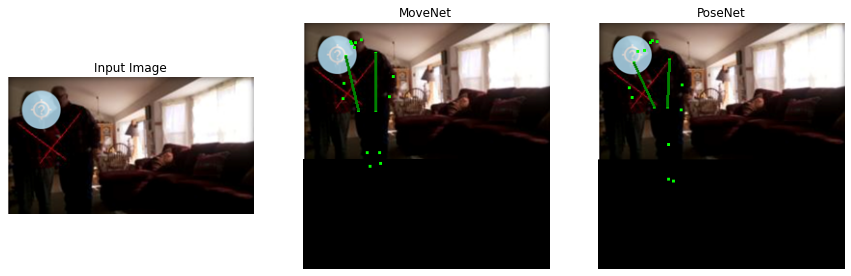


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.681931         0.584232    0.564107    0.636249
posenet         0.693424         0.361835    0.746721    0.579940



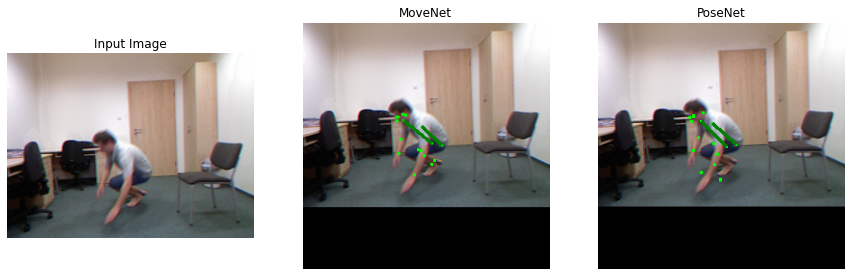


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.551456         0.685538    0.571250    0.497153
posenet         0.984250         0.821950    0.874787    0.944533



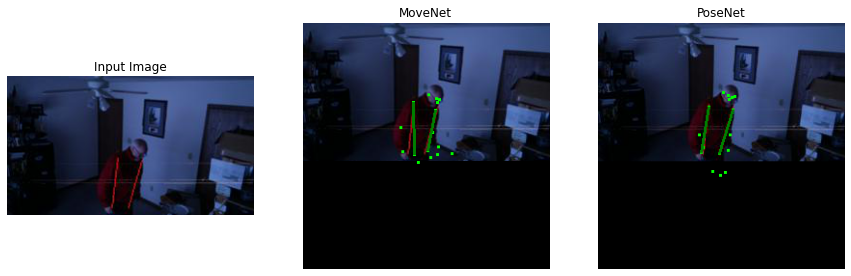


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.514818         0.482569    0.634595    0.475726
posenet         0.816953         0.787055    0.619340    0.432841



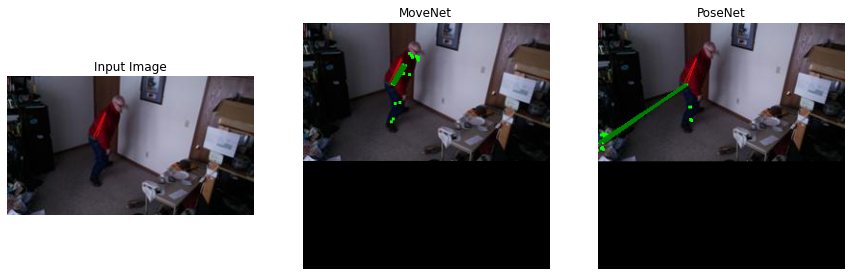


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.293247         0.280729    0.428215    0.462449
posenet         0.080133         0.064593    0.137335    0.169320



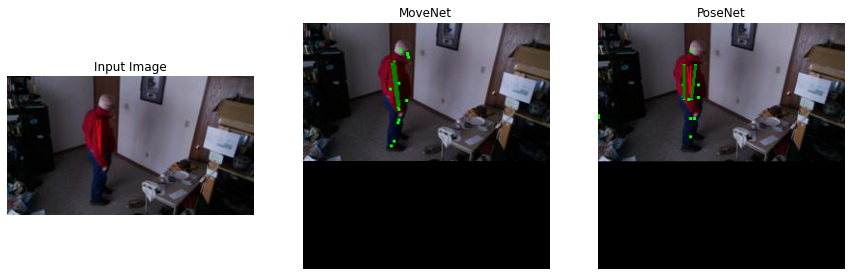


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.291344         0.409784    0.505634    0.557062
posenet         0.358750         0.380527    0.474331    0.578293



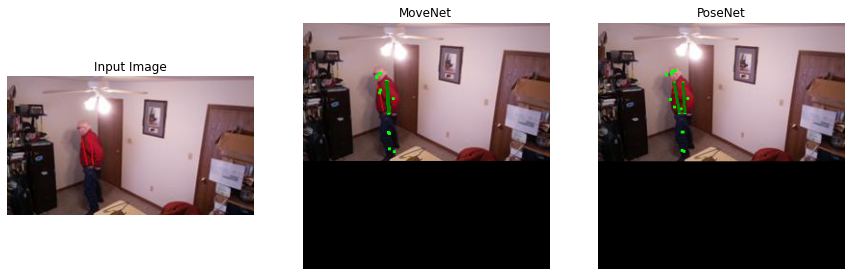


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.385434         0.443162    0.457041    0.452207
posenet         0.993103         0.882560    0.989262    0.947945



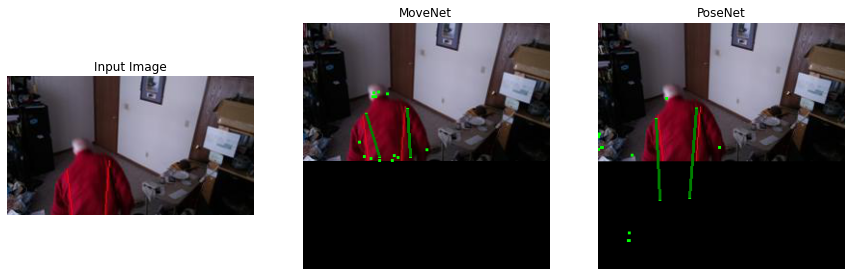


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.579216         0.608702    0.172724    0.137664
posenet         0.437934         0.132671    0.211096    0.093292



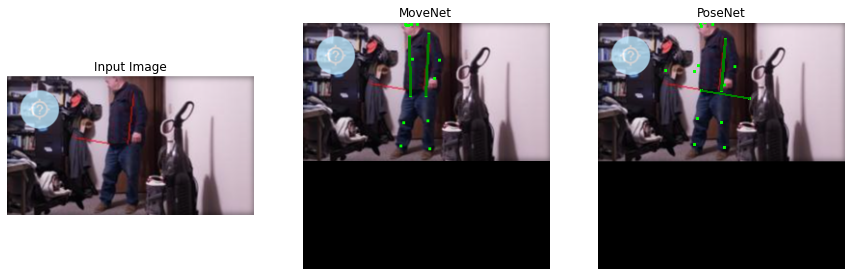


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.671804         0.560217    0.708826    0.771402
posenet         0.994041         0.837409    0.998104    0.975233



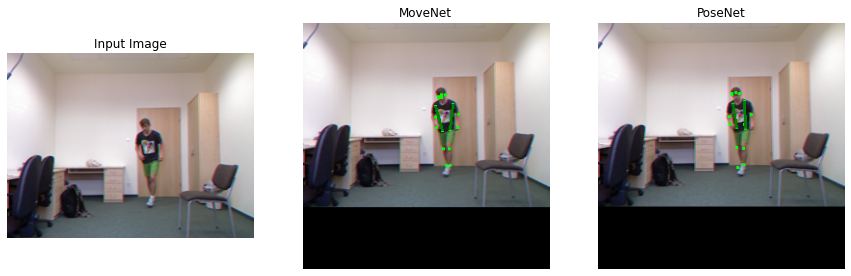


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.574028         0.661798    0.480063    0.483903
posenet         0.966646         0.948529    0.926106    0.748626



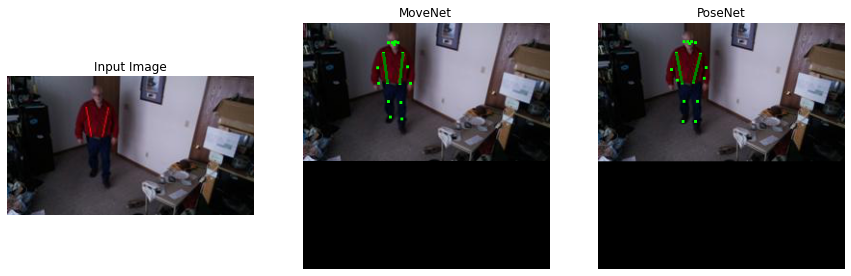


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.404683         0.323303    0.628407    0.531737
posenet         0.994282         0.981373    0.995236    0.992494



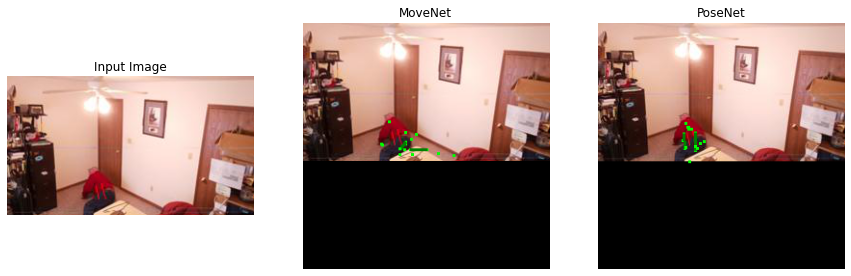


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.060427         0.090580    0.245573    0.340671
posenet         0.064809         0.060697    0.029433    0.048051



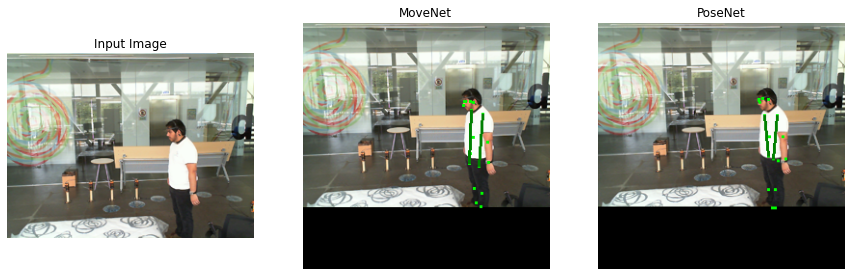


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.576428         0.593523    0.652052    0.692571
posenet         0.999428         0.971296    0.929319    0.827800



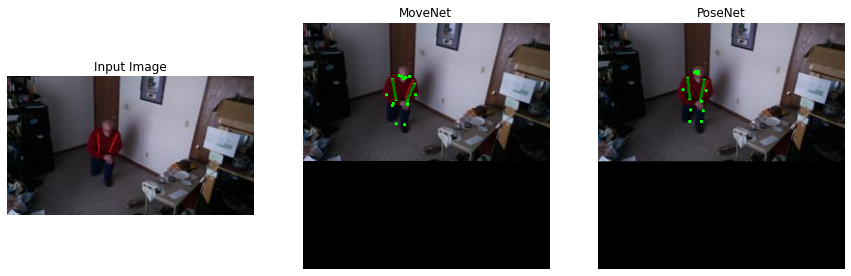


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.482164         0.407906    0.389751    0.356103
posenet         0.676122         0.718254    0.509295    0.618937



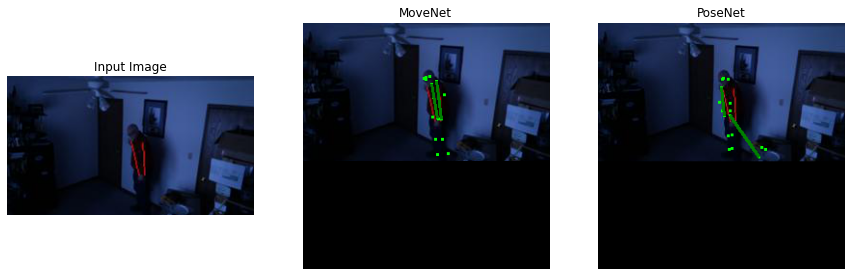


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.411386         0.387539    0.387879    0.432138
posenet         0.028315         0.037679    0.026444    0.043686



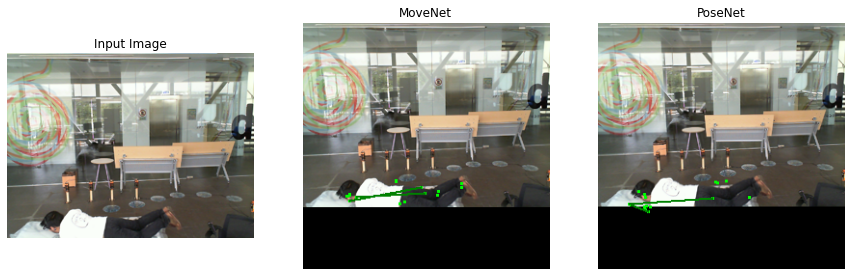


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.272308         0.308843    0.197490    0.171467
posenet         0.011118         0.017692    0.005691    0.006544



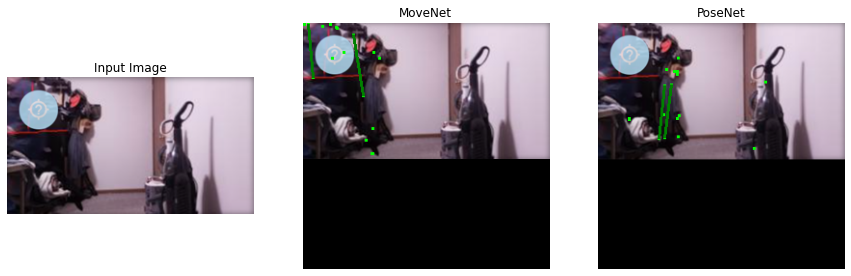


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.065165         0.159040    0.078886    0.121895
posenet         0.640908         0.661787    0.309637    0.311637



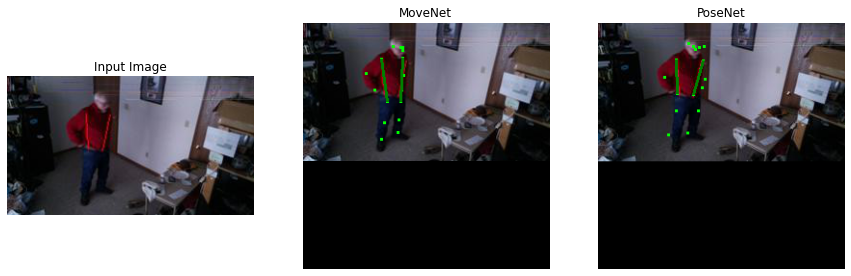


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.475422         0.576229    0.795356    0.678322
posenet         0.522550         0.907768    0.935941    0.754716



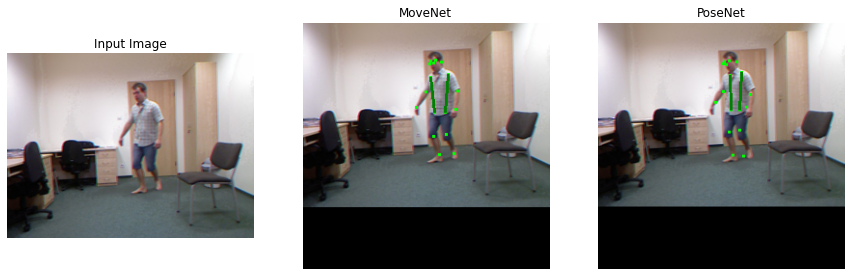


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.722023         0.518078    0.559008    0.590755
posenet         0.993478         0.997292    0.993563    0.996355



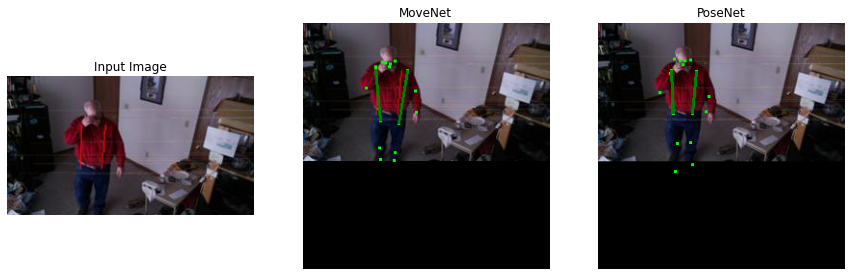


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.463634         0.651494    0.533021    0.667355
posenet         0.990964         0.883968    0.999335    0.954334



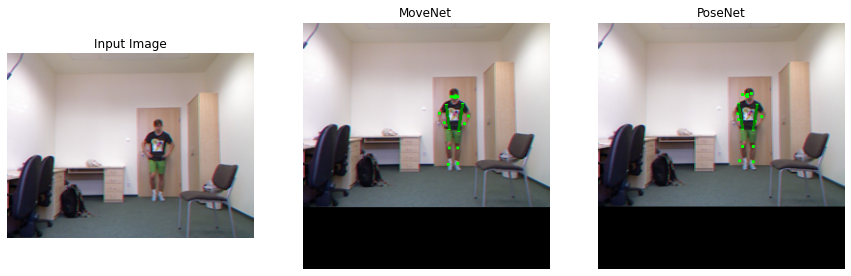


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.649309         0.577869    0.570143    0.533052
posenet         0.984572         0.941343    0.940407    0.924790



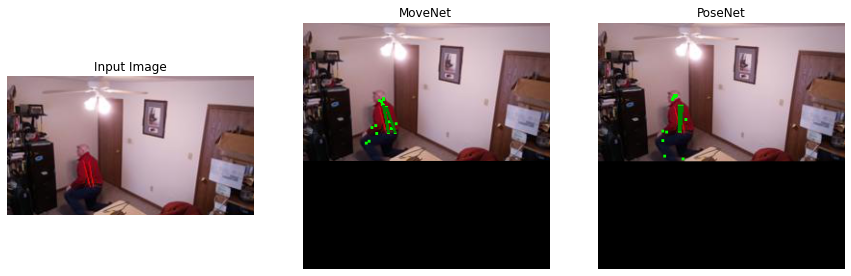


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.351813         0.285500    0.257874    0.301363
posenet         0.789852         0.866329    0.808955    0.776207



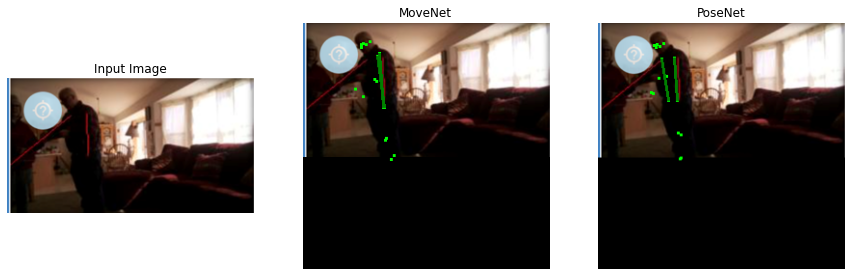


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.698904         0.492375    0.528615    0.548247
posenet         0.955995         0.962668    0.846824    0.864783



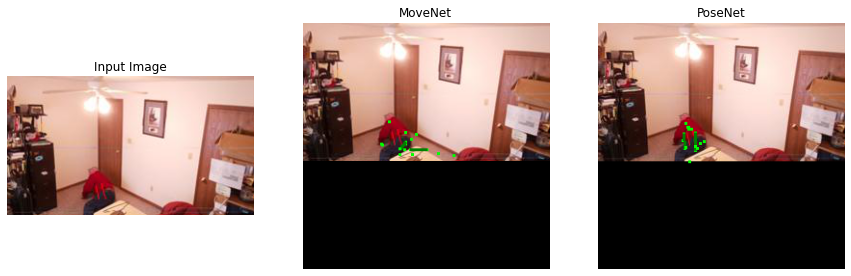


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.060427         0.090580    0.245573    0.340671
posenet         0.064809         0.060697    0.029433    0.048051



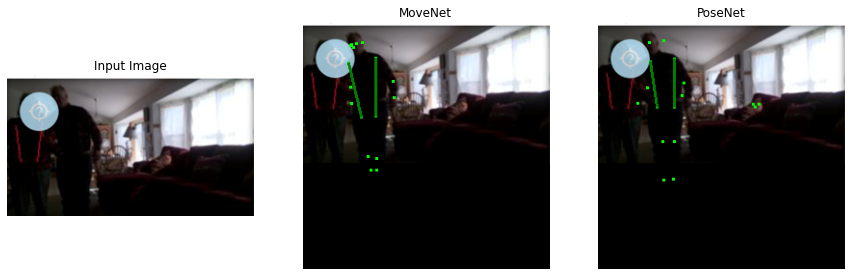


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.705922         0.629298    0.577361    0.644588
posenet         0.890897         0.707792    0.991340    0.855217



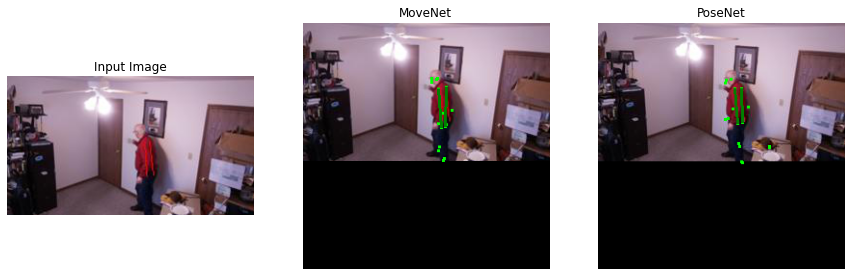


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.709016         0.488553    0.673661    0.542462
posenet         0.832334         0.937849    0.724507    0.842540



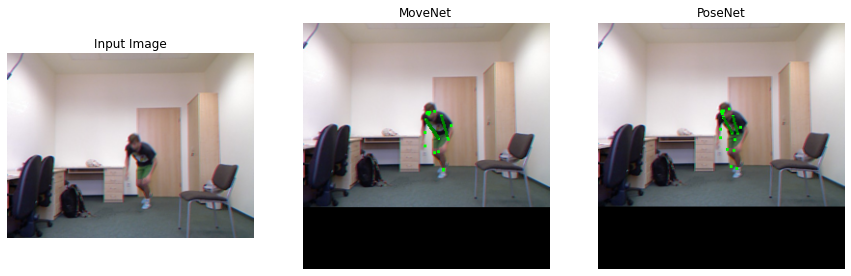


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.467571         0.432707    0.533694    0.443868
posenet         0.938513         0.992204    0.895669    0.907810



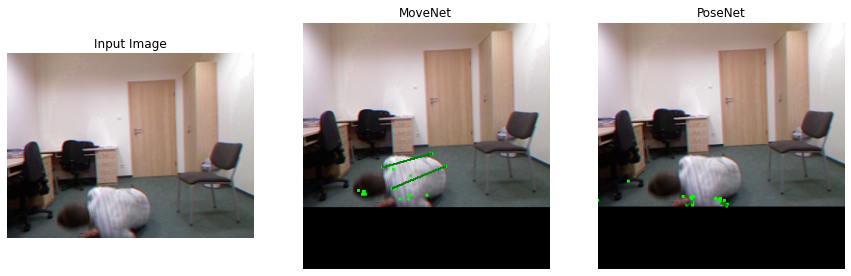


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.203491         0.159094    0.293808    0.355324
posenet         0.004774         0.005587    0.001251    0.001916



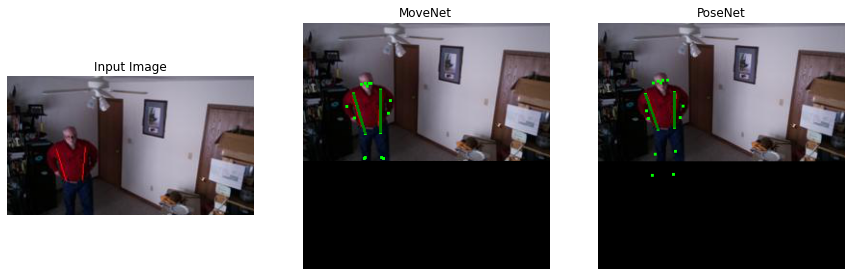


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.563815         0.644333    0.536523    0.575942
posenet         0.932518         0.951447    0.859028    0.974499



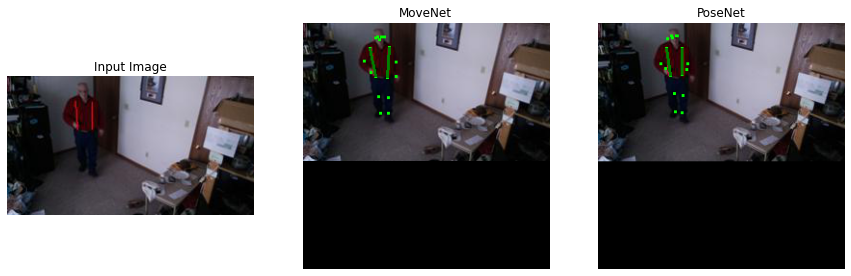


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.608533         0.695414    0.584076    0.577192
posenet         0.994645         0.998270    0.990977    0.988087



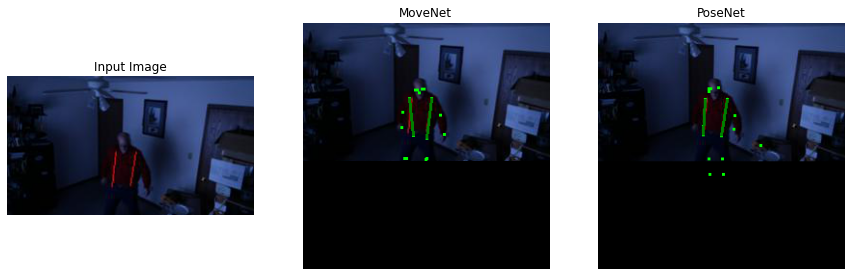


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.664438         0.450119    0.566757    0.627638
posenet         0.909101         0.721479    0.985621    0.808457



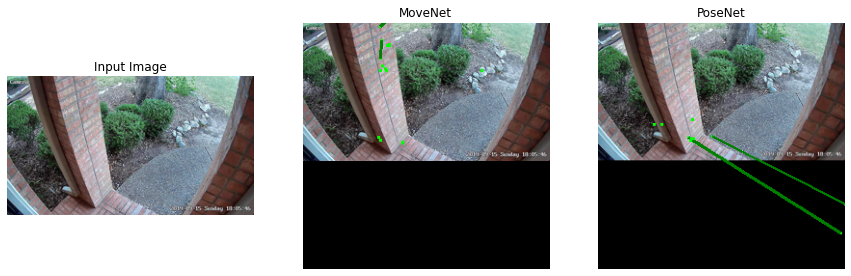


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.011379         0.027955    0.012385    0.031742
posenet         0.003143         0.001506    0.009571    0.006482



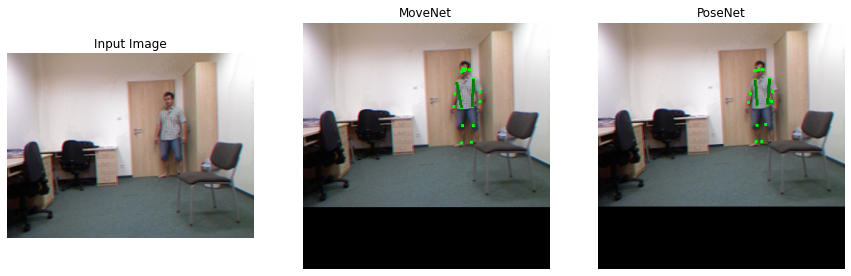


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.368592         0.407846    0.507245    0.531825
posenet         0.900541         0.994566    0.941537    0.994153



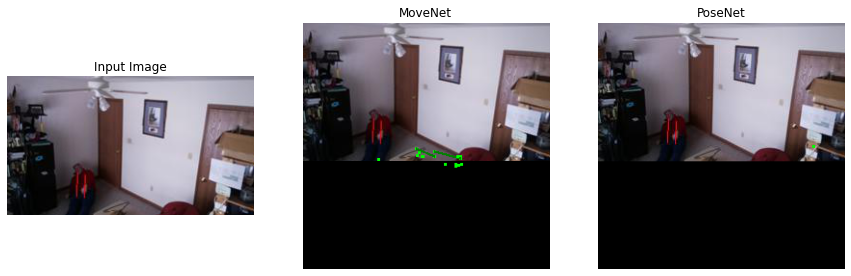


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.194734         0.153794    0.137529    0.105855
posenet         0.003191         0.005295    0.004226    0.005557



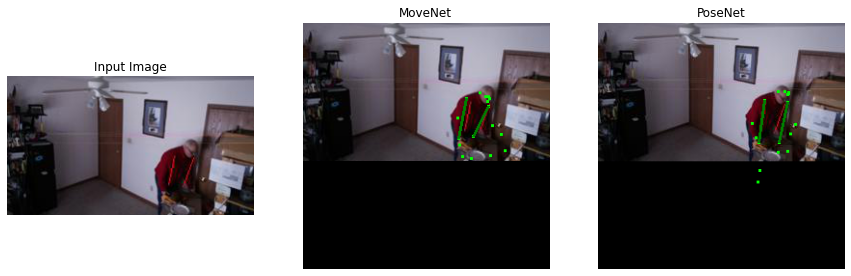


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.452735         0.561610    0.615249    0.632142
posenet         0.927438         0.873117    0.944495    0.948101



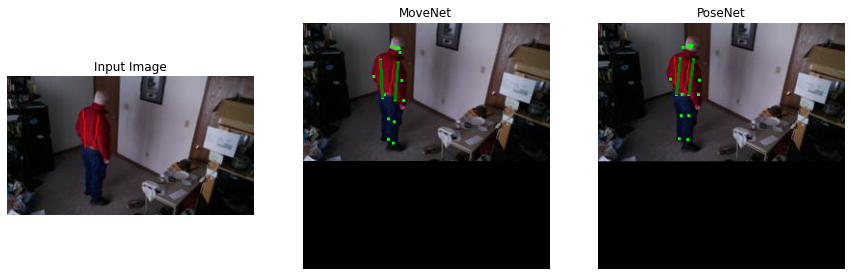


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.484826         0.600958    0.633970    0.499901
posenet         0.782442         0.947943    0.930646    0.991978



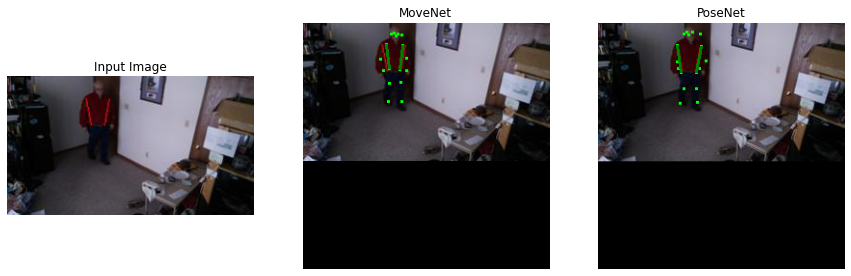


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.422469         0.647568    0.642164    0.616533
posenet         0.941262         0.934462    0.984502    0.965508



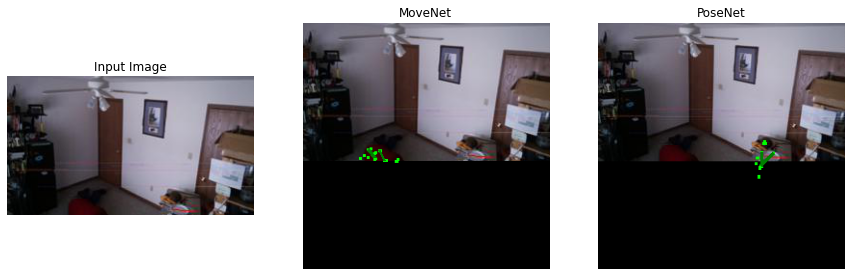


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.287768         0.225122    0.151572    0.131170
posenet         0.049259         0.039406    0.015937    0.019279



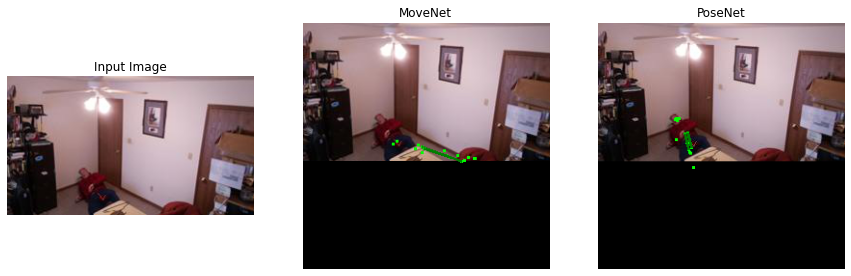


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet          0.09763         0.090282    0.114824    0.156920
posenet          0.13359         0.085984    0.109510    0.137726



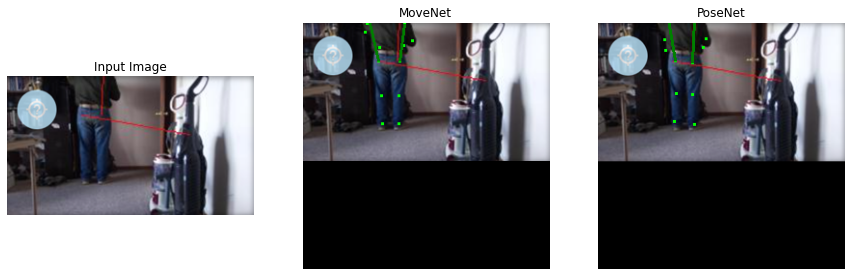


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.168734         0.167558    0.614498    0.572880
posenet         0.645109         0.945679    0.892022    0.992411



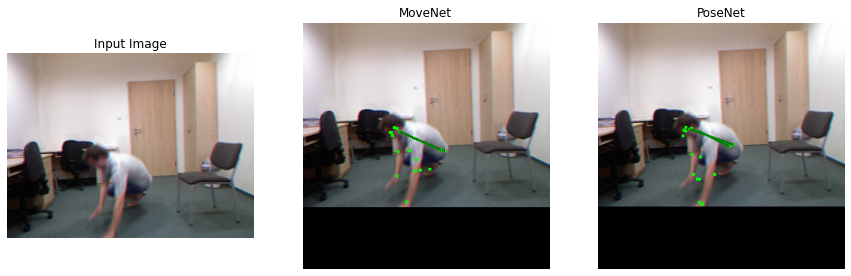


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.628801         0.674815    0.619655    0.794412
posenet         0.955991         0.907969    0.850242    0.781131



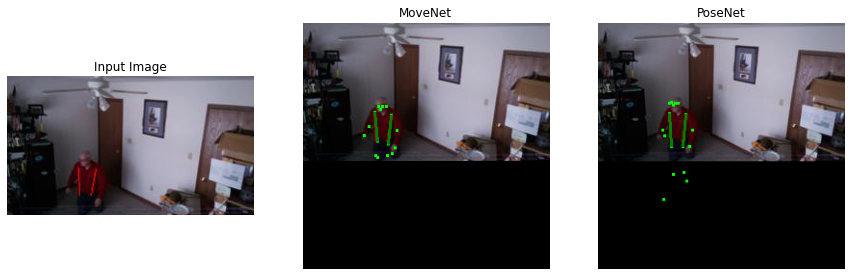


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.361243         0.604967    0.296043    0.329389
posenet         0.987998         0.953838    0.964929    0.861641



In [12]:
import os
DATADIR = 'Images'
comparison_df = pd.DataFrame()

for template_path in os.listdir(DATADIR):
  
    template_image_src = Image.open(os.path.join(DATADIR,template_path))    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(256, 256)) # input image
    movenet_output_image, movenet_scoreList = movenet_model_detection(template_image_src.copy())
    posenet_output_image, posenet_scoreList = posenet_model_detection(template_image_src.copy())
    
    scoreList_table = pd.DataFrame(data = [movenet_scoreList, posenet_scoreList],
                                   columns = ['LShoulder_score','RShoulder_score','LHip_score','RHip_score'], 
                                   index=['movenet','posenet'])
    
    fig = plt.figure(figsize=(15,9))
    fig.add_subplot(1, 3, 1)
    plt.imshow(_thumbnail)    
    plt.axis("off")
    plt.title("Input Image")

    fig.add_subplot(1, 3, 2)
    plt.imshow(movenet_output_image)    
    plt.axis("off")
    plt.title("MoveNet")        

    fig.add_subplot(1, 3, 3)
    plt.imshow(posenet_output_image)    
    plt.axis("off")
    plt.title("PoseNet")        
    
    plt.show()
    
    
    print()
    print(scoreList_table)
    print()

    idx = scoreList_table.index.to_frame()
    idx.insert(0, 'image', template_path)
    idx.insert(1, 'model', ['movenet','posenet'])
    scoreList_table = scoreList_table.set_index(pd.MultiIndex.from_frame(idx),drop=True).droplevel(2)
    comparison_df = comparison_df.append(scoreList_table)

In [13]:
comparison_df

LShoulder_score  RShoulder_score  LHip_score  \
image           model                                                   
fall_img_46.png movenet         0.681931         0.584232    0.564107   
                posenet         0.693424         0.361835    0.746721   
fall_img_2.png  movenet         0.551456         0.685538    0.571250   
                posenet         0.984250         0.821950    0.874787   
fall_img_31.jpg movenet         0.514818         0.482569    0.634595   
                posenet         0.816953         0.787055    0.619340   
fall_img_45.jpg movenet         0.293247         0.280729    0.428215   
                posenet         0.080133         0.064593    0.137335   
fall_img_43.jpg movenet         0.291344         0.409784    0.505634   
                posenet         0.358750         0.380527    0.474331   
fall_img_27.jpg movenet         0.385434         0.443162    0.457041   
                posenet         0.993103         0.882560    0.989262   
fall_img_36.jpg movenet         0.579216         0.608702    0.172724   
                posenet         0.437934         0.132671    0.211096   
fall_img_18.png movenet         0.671804         0.560217    0.708826   
                posenet         0.994041         0.837409    0.998104   
fall_img_6.png  movenet         0.574028         0.661798    0.480063   
                posenet         0.966646         0.948529    0.926106   
fall_img_38.jpg movenet         0.404683         0.323303    0.628407   
                posenet         0.994282         0.981373    0.995236   
fall_img_22.jpg movenet         0.060427         0.090580    0.245573   
                posenet         0.064809         0.060697    0.029433   
fall_img_8.png  movenet         0.576428         0.593523    0.652052   
                posenet         0.999428         0.971296    0.929319   
fall_img_41.jpg movenet         0.482164         0.407906    0.389751   
                posenet         0.676122         0.718254    0.509295   
fall_img_29.jpg movenet         0.411386         0.387539    0.387879   
                posenet         0.028315         0.037679    0.026444   
fall_img_9.png  movenet         0.272308         0.308843    0.197490   
                posenet         0.011118         0.017692    0.005691   
fall_img_19.png movenet         0.065165         0.159040    0.078886   
                posenet         0.640908         0.661787    0.309637   
fall_img_42.jpg movenet         0.475422         0.576229    0.795356   
                posenet         0.522550         0.907768    0.935941   
fall_img_1.png  movenet         0.722023         0.518078    0.559008   
                posenet         0.993478         0.997292    0.993563   
fall_img_39.jpg movenet         0.463634         0.651494    0.533021   
                posenet         0.990964         0.883968    0.999335   
fall_img_5.png  movenet         0.649309         0.577869    0.570143   
                posenet         0.984572         0.941343    0.940407   
fall_img_26.jpg movenet         0.351813         0.285500    0.257874   
                posenet         0.789852         0.866329    0.808955   
fall_img_47.png movenet         0.698904         0.492375    0.528615   
                posenet         0.955995         0.962668    0.846824   
fall_img_23.jpg movenet         0.060427         0.090580    0.245573   
                posenet         0.064809         0.060697    0.029433   
fall_img_48.png movenet         0.705922         0.629298    0.577361   
                posenet         0.890897         0.707792    0.991340   
fall_img_28.jpg movenet         0.709016         0.488553    0.673661   
                posenet         0.832334         0.937849    0.724507   
fall_img_7.png  movenet         0.467571         0.432707    0.533694   
                posenet         0.938513         0.992204    0.895669   
fall_img_4.png  movenet         0.203491         0.159094    0.293808   
          